# Кольца Артем М.19-04

### Кластеризация графа. Affinity propagation

### Задание №4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
%matplotlib inline

In [2]:
NODES = 196591 # количество пользователей
EDGES = 950327 # связи между пользователями
CHECK_INS = 6442890 # всего чекинов

In [3]:
with open('Gowalla_edges.txt', 'r') as f:
    all_strings = f.readlines()
edges_list = [] # список всех связей
nodes_list = set() # множество всех пользователей
similarity_array = [] # массив similarity (без self-similarity)
# итерируемся по всем строкам файла
for line in all_strings:
    user_1, user_2 = line.split()
    # заполняем список всех связей в формате: (кто дружит, с кем дружит)
    edges_list.append((int(user_1), int(user_2)))
    nodes_list.add((int(user_1)))
    # каждую дружбу отмечаем 1 в similarity
    similarity_array.append(1)
# дополним список связей связями "сам к себе"
for node in nodes_list:
    edges_list.append((node, node))

similarity_array = np.array(similarity_array, dtype=np.int8)
all_strings = None

In [4]:
len(nodes_list)

196591

In [5]:
len(similarity_array)

1900654

In [6]:
np.shape(edges_list)

(2097245, 2)

In [7]:
def update_responsibility(S, A, edges):
    # поэлементное сложение массивов similarity и availability
    #s(i,j) + a(i,j)
    V = S + A
    
    max_1 = np.repeat(-np.inf, NODES)
    max_2 = np.repeat(-np.inf, NODES)
    max_1_user_2 = np.repeat(np.inf, NODES)

    # итерируемся по списку связей
    for idx, (user_1, user_2) in enumerate(edges):
        # для каждого пользователя найдем 2 наибольших значения суммы V
        if max_1[user_1] < V[idx]:
            max_2[user_1] = max_1[user_1]
            max_1[user_1] = V[idx]
            # запоминаем второго пользователя с которым у пользователя 1 максимальное V
            max_1_user_2[user_1] = user_2
        elif max_2[user_1] < V[idx]:
            max_2[user_1] = V[idx]
    # обновляем  массив responsibility
    R = S.copy()
    for idx, (user_1, user_2) in enumerate(edges):
        if max_1_user_2[user_1] == user_2:
            R[idx] -= max_2[user_1]
        else:
            R[idx] -= max_1[user_1]
    
    return R

In [8]:
def update_availability(A, R, edges):
    # сохраняем только положительные r, self-r не изменяем
    R_copy = R.copy()
    # max между 0 и значением responsibility 'ответственности'
    i = 0
    while i < EDGES * 2:
        if R_copy[i] < 0:
            R_copy[i] = 0
        i += 1
    # для каждого пользователя складываем положительные r от других пользователей
    positive_r = np.repeat(0, NODES)
    
    for idx, (user_1, user_2) in enumerate(edges):
        positive_r[user_2] += R_copy[idx]
    # обновляем availability
    for idx, (user_1, user_2) in enumerate(edges):
        A[idx] = positive_r[user_2] - R_copy[idx]
        
    # вычисление min
    i = 0
    while i < EDGES * 2:
        A[i] = np.min([0, A[i]])
        i += 1
    
    return A

In [9]:
def get_exemplars(A, R, edges, transitivity_param):
    temp = np.repeat(-np.inf, NODES)
    exemplars_dict = dict()
    # поэлементное сложение массивов availability и responsibility
    value_sum = A + R
    # для каждого пользователя 1 определяем пользователя 2 c максимальным value_sum
    for idx, (user_1, user_2) in enumerate(edges):
        #находим максимальное значение
        #если value_sum для этого пользователя больше, чем сохраненное максимальное значение, то обновляем
        if value_sum[idx] > temp[user_1]:
            temp[user_1] = value_sum[idx]
            exemplars_dict[user_1] = user_2
    
    for i in range(transitivity_param):        
        for exempl_a in exemplars_dict.keys(): 
            exempl_b = exemplars_dict[exempl_a]
            if exemplars_dict[exempl_b] != exempl_b:
                exempl_с = exemplars_dict[exempl_b]
                exemplars_dict[exempl_a] = exempl_с
                
    return exemplars_dict

In [10]:
def affinity_propagation(s, edges, num_iter, self_similarity):
    #создаем массив self-similarity
    self_s_array = np.repeat(self_similarity, NODES)
    #создем полный массив similarity (значения self-similarity будут в конце массива)
    similarity = np.append(s, self_s_array)
    
    # инициализируем нулями массивы availability и responsibility
    responsibility_array = np.repeat(0, similarity.shape[0])
    availability_array = np.repeat(0, similarity.shape[0])

    for i in range(num_iter):
        # обновляем responsibility
        responsibility_array = update_responsibility(similarity, availability_array, edges)
        # обновляем availability
        availability_array = update_availability(availability_array, responsibility_array, edges)
        print(i)
    #Получаем экземпляр кластера для каждого пользователя и производим транзитивную свертку
    exemplars = get_exemplars(availability_array, responsibility_array, edges_list, transitivity_param = 5)
    
    return exemplars

In [11]:
my_exemplars = affinity_propagation(similarity_array, edges_list, num_iter = 10, self_similarity = -1.5)

0
1
2
3
4
5
6
7
8
9


In [12]:
#Количество кластеров
clusters = sorted(list(set(my_exemplars.values())))
print("Количество кластеров:", len(clusters))

Количество кластеров: 17955


In [13]:
#Визуализация размеров кластера
cluster_size = dict()
for exemplar in my_exemplars.values():
    if exemplar not in cluster_size:
        cluster_size[exemplar] = 1
    else:
        cluster_size[exemplar] += 1
print("Максимальный размер кластера:", max(cluster_size.values()))
print("Минимальный размер кластера:", min(cluster_size.values()))

Максимальный размер кластера: 16100
Минимальный размер кластера: 1


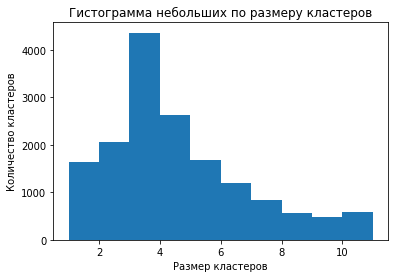

In [14]:
#Визуализация минимальных размеров кластеров
plt.hist(cluster_size.values(),bins= range(1,12), range=(0, 11))
plt.xlabel("Размер кластеров")
plt.ylabel("Количество кластеров")
plt.title("Гистограмма небольших по размеру кластеров")
plt.show()

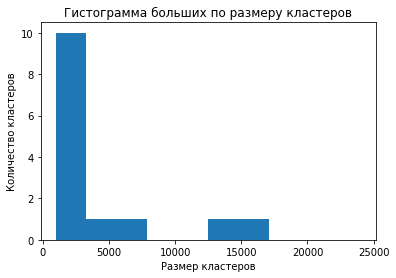

In [15]:
#Визуализация максимальных размеров кластеров
plt.hist(cluster_size.values(), bins=10, range=(1000, 24000))
plt.xlabel("Размер кластеров")
plt.ylabel("Количество кластеров")
plt.title("Гистограмма больших по размеру кластеров")
plt.show()

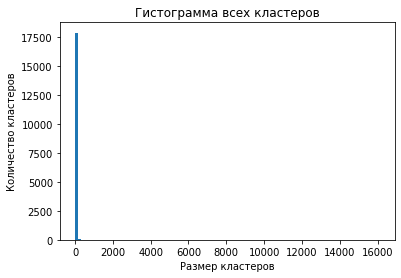

In [16]:
#Визуализация всех размеров кластеров
plt.hist(cluster_size.values(), bins=100)
plt.xlabel("Размер кластеров")
plt.ylabel("Количество кластеров")
plt.title("Гистограмма всех кластеров")
plt.show()

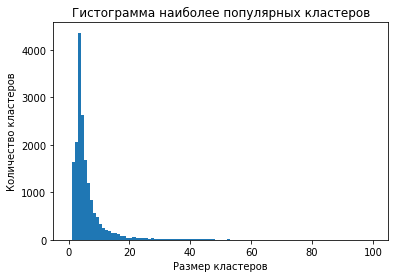

In [17]:
#Визуализация наиболее распространенных размеров кластеров
plt.hist(cluster_size.values(), bins=100, range=(0, 100))
plt.xlabel("Размер кластеров")
plt.ylabel("Количество кластеров")
plt.title("Гистограмма наиболее популярных кластеров")
plt.show()

In [18]:
#Обработка данных по чекинам
import pandas as pd
df_checkins = pd.read_csv("Gowalla_totalCheckins.txt", sep="	", header=None)[[0, 4]]
df_checkins.columns = ["user_id", "location_id"]

print(len(df_checkins))
df_checkins.head()

6442892


,user_id,location_id
0,0,22847
1,0,420315
2,0,316637
3,0,16516
4,0,5535878


In [19]:
clusters_for_df=(list(my_exemplars.values()))
print(len(clusters_for_df))

196591


In [20]:
df_clusters = pd.DataFrame(clusters_for_df)
df_clusters = df_clusters.reset_index()
df_clusters.columns = ["user_id", "cluster_id"]
print(len(df_clusters))
df_clusters.head()

196591


,user_id,cluster_id
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4


In [21]:
df = pd.merge(df_checkins, df_clusters, on=['user_id'])
print(len(df))
df.head()

6442892


,user_id,location_id,cluster_id
0,0,22847,0
1,0,420315,0
2,0,316637,0
3,0,16516,0
4,0,5535878,0


In [22]:
#Определим количество пользователей, оставлявших чекины
users_with_location = np.unique(df_checkins.user_id)
print(len(users_with_location))

107092


In [23]:
#Разделим выборку пользователей на тестовую и тренировочную
#И перемешаем данные
#Тестовую выборку определим в 10% от всей
from sklearn.model_selection import train_test_split
train_users, test_users = train_test_split(users_with_location, test_size=0.1, shuffle=True)
print(np.shape(train_users))
print(np.shape(test_users))

(96382,)
(10710,)


In [24]:
train_checkins = df.loc[df.user_id.isin(train_users)]
test_checkins = df.loc[df.user_id.isin(test_users)]
test_checkins.head()

,user_id,location_id,cluster_id
2712,9,3010334,9
2713,9,39610,9
2714,9,123529,9
2715,9,114086,9
2716,9,347561,9


In [25]:
#Возьмем гипотезу о том, что все пользователи находятся в 1 кластере
#Будем мерить метрикой precision@10
#На тренеровочной выборке определим ТОП 10 локаций с максимальным чекином
#Отсортируем в порядке убывания количества чекинов
top10_locations = list(train_checkins.groupby(by='location_id')['location_id'].count().sort_values(ascending = False).iloc[:10].index)
print(top10_locations)

[55033, 19542, 9410, 10259, 58725, 9246, 10190, 23256, 9241, 14470]


In [26]:
#для отслеживания топ значений локаций кластера
#train_loc_ratings = количество раз, когда пользователь в этом кластере регистрируется в этой локации
train_loc_ratings = train_checkins.groupby(by = ["cluster_id", "location_id"])["location_id"].count()

train_loc_ratings = train_loc_ratings.reset_index(name='rating').sort_values(by = ["cluster_id", "rating"], ascending = False)
train_loc_ratings.head()

,cluster_id,location_id,rating
3090268,196539,103606,11
3090274,196539,271694,5
3090269,196539,124683,1
3090270,196539,128331,1
3090271,196539,130147,1


In [29]:
# Рассчитаем precision@10 с применением кластеризации
def get_tp(top_data, pred_data, k = 10):
    try:
        top_data = set(top_data[:k])
    except:
        top_data = set(top_data)
    pred_data = set(pred_data)
    return len(top_data.intersection(pred_data))

amount_counter = 10*len(test_users)
tp_base = 0
tp_cluster = 0
denom = len(test_users)*10

for user in test_users:
    cluster = clusters_for_df[user]
    user_locations = test_checkins.loc[test_checkins.user_id == user, "location_id"].values
    if (cluster in train_loc_ratings.cluster_id):
        top_cluster = train_loc_ratings.loc[train_loc_ratings.cluster_id == cluster, "location_id"].values        
        tp_cluster += get_tp(top_cluster, user_locations)

    tp_base += get_tp(top10_locations, user_locations)

base_precision=tp_base/denom
cluster_precision=tp_cluster/denom
print("Self-similarity: -1.5")
print("Количество итераций: 10")
print("Количество кластеров:", len(clusters))
print("Prectidion base: ", base_precision)
print("Prectidion кластеров: ", cluster_precision)

Self-similarity: -1.5
Количество итераций: 10
Количество кластеров: 17955
Prectidion base:  0.017096171802054156
Prectidion кластеров:  0.036591970121381885
